In [58]:
from pathlib import Path

import numpy as np
from numba import njit, prange

from matplotlib import pyplot as plt

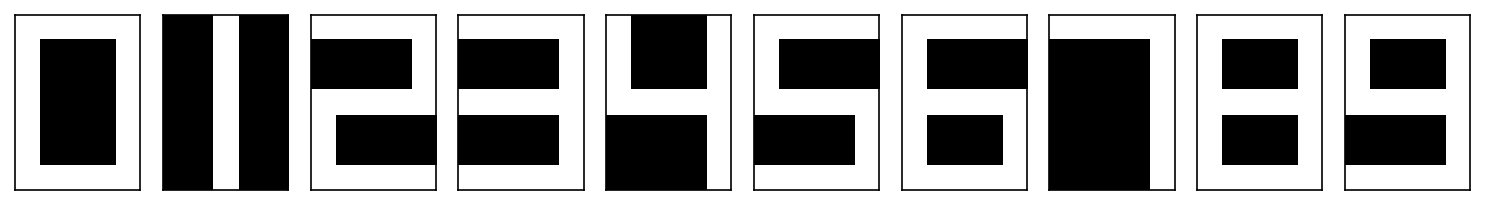

In [59]:
img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [60]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [61]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.5, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

In [62]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

In [63]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)

@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)

@njit(fastmath=True)
def Tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)

@njit(fastmath=True)
def dTanh(x: np.ndarray) -> np.ndarray:
    return 1-np.square(np.tanh(x))

@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))

@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)

@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [64]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, V: np.ndarray, W: np.ndarray, c: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    u = np.zeros((V.shape[0], V.shape[1]))
    h = np.zeros((V.shape[0],V.shape[1]))
    z = np.zeros(W.shape[1])
    
    for i in range(xBatch.shape[0]):
        z *= 0

        for j in range(V.shape[0]):
            u[j] = V[j] @ xBatch[i] + c[j]
            h[j] = ReLU(u[j])
            z += W[j] @ h[j]

        y = softmax(z + b)

        for j in range(V.shape[0]):
            dLdu = W[j].T @ (y - yBatch[i]) * dReLU(u[j])
            dV[j] += np.outer(dLdu , xBatch[i])
            dc[j] += dLdu
        
        for j in range(V.shape[0]):
            dW[j] += np.outer(y - yBatch[i], h[j])

        db += y - yBatch[i]
    
    return (dV, dW, dc, db)


class WidePerceptron:
    def __init__(self, nIn: int, nH:int, nL:int, nOut: int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nL = nL
        self.nOut = nOut
        
        self.V: np.ndarray = np.random.uniform(-1, 1, (nL, nH, nIn))
        self.c: np.ndarray = np.zeros((nL, nH))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nH))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        z = np.zeros(self.nOut)

        for i in range(self.nL):
            u = ReLU(self.V[i] @ x + self.c[i])
            z += self.W[i] @ u
                
        return softmax(z + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n//batch_size):
                ibegin, iend = batch_idx*batch_size, min((batch_idx+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]
            
                dV, dW, dc, db = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.V, self.W, self.c, self.b)

                self.V -= lr*dV
                self.c -= lr*dc

                self.W -= lr*dW
                self.b -= lr*db
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(Ypred), axis=1)
        return np.mean(h)

In [73]:
nIn = 35
nH = 8
nL = 4
nOut = 10

learning_rate = 1e-2
batch_size = 16
max_epoch = 256

model = WidePerceptron(nIn, nH, nL, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(4))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(x_test, y_test).round(4))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    y_pred = model.predict(x)
    n_true_pos += 1 if np.argmax(y_pred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  1.4629
trained loss:  0.0004
test set accuracy: 100.0%


In [74]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y = model.predict(x)
    n_true_pos += 1 if j == np.argmax(y) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}%")

accuracy: 90.89%


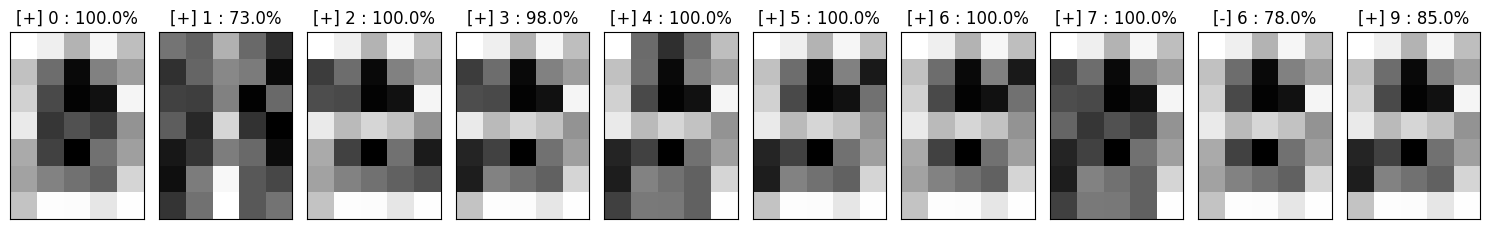

In [75]:
noise_size = 1.0

x_noised = data_mtrx + np.random.uniform(0.0, noise_size, img_size)
y = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(y[i])

    ax.set_title(f"[{'+' if j == i else '-'}] {j} : {(y[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()